In [2]:
# Enable module reloading
%load_ext autoreload
%autoreload 2

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import math
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import sys
sys.path.insert(1, '../')

from src import preprocessing as pp
from src import analysis

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')

X_val = pd.read_csv('../data/X_val.csv')
y_val = pd.read_csv('../data/y_val.csv')

In [5]:
# TODO: fix wrong saved files
y_train = y_train['rating']
y_val = y_val['rating']

In [47]:
def print_metrics(y_true, y_pred):
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    fig, axs = plt.subplots(nrows=3, figsize=(12, 15))
    data = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred, 'diff': abs(y_pred - y_true)})
    sns.boxplot(x="y_true", y="y_pred", data=data, ax=axs[0])
    sns.boxplot(x="y_true", y="diff", data=data, ax=axs[1])
    sns.distplot(y_true, ax=axs[2])

# Dummy approach - using mean as prediction

MSE: 1.4012763090592244
RMSE: 1.1837551727697853
MAE: 0.9000991851004203


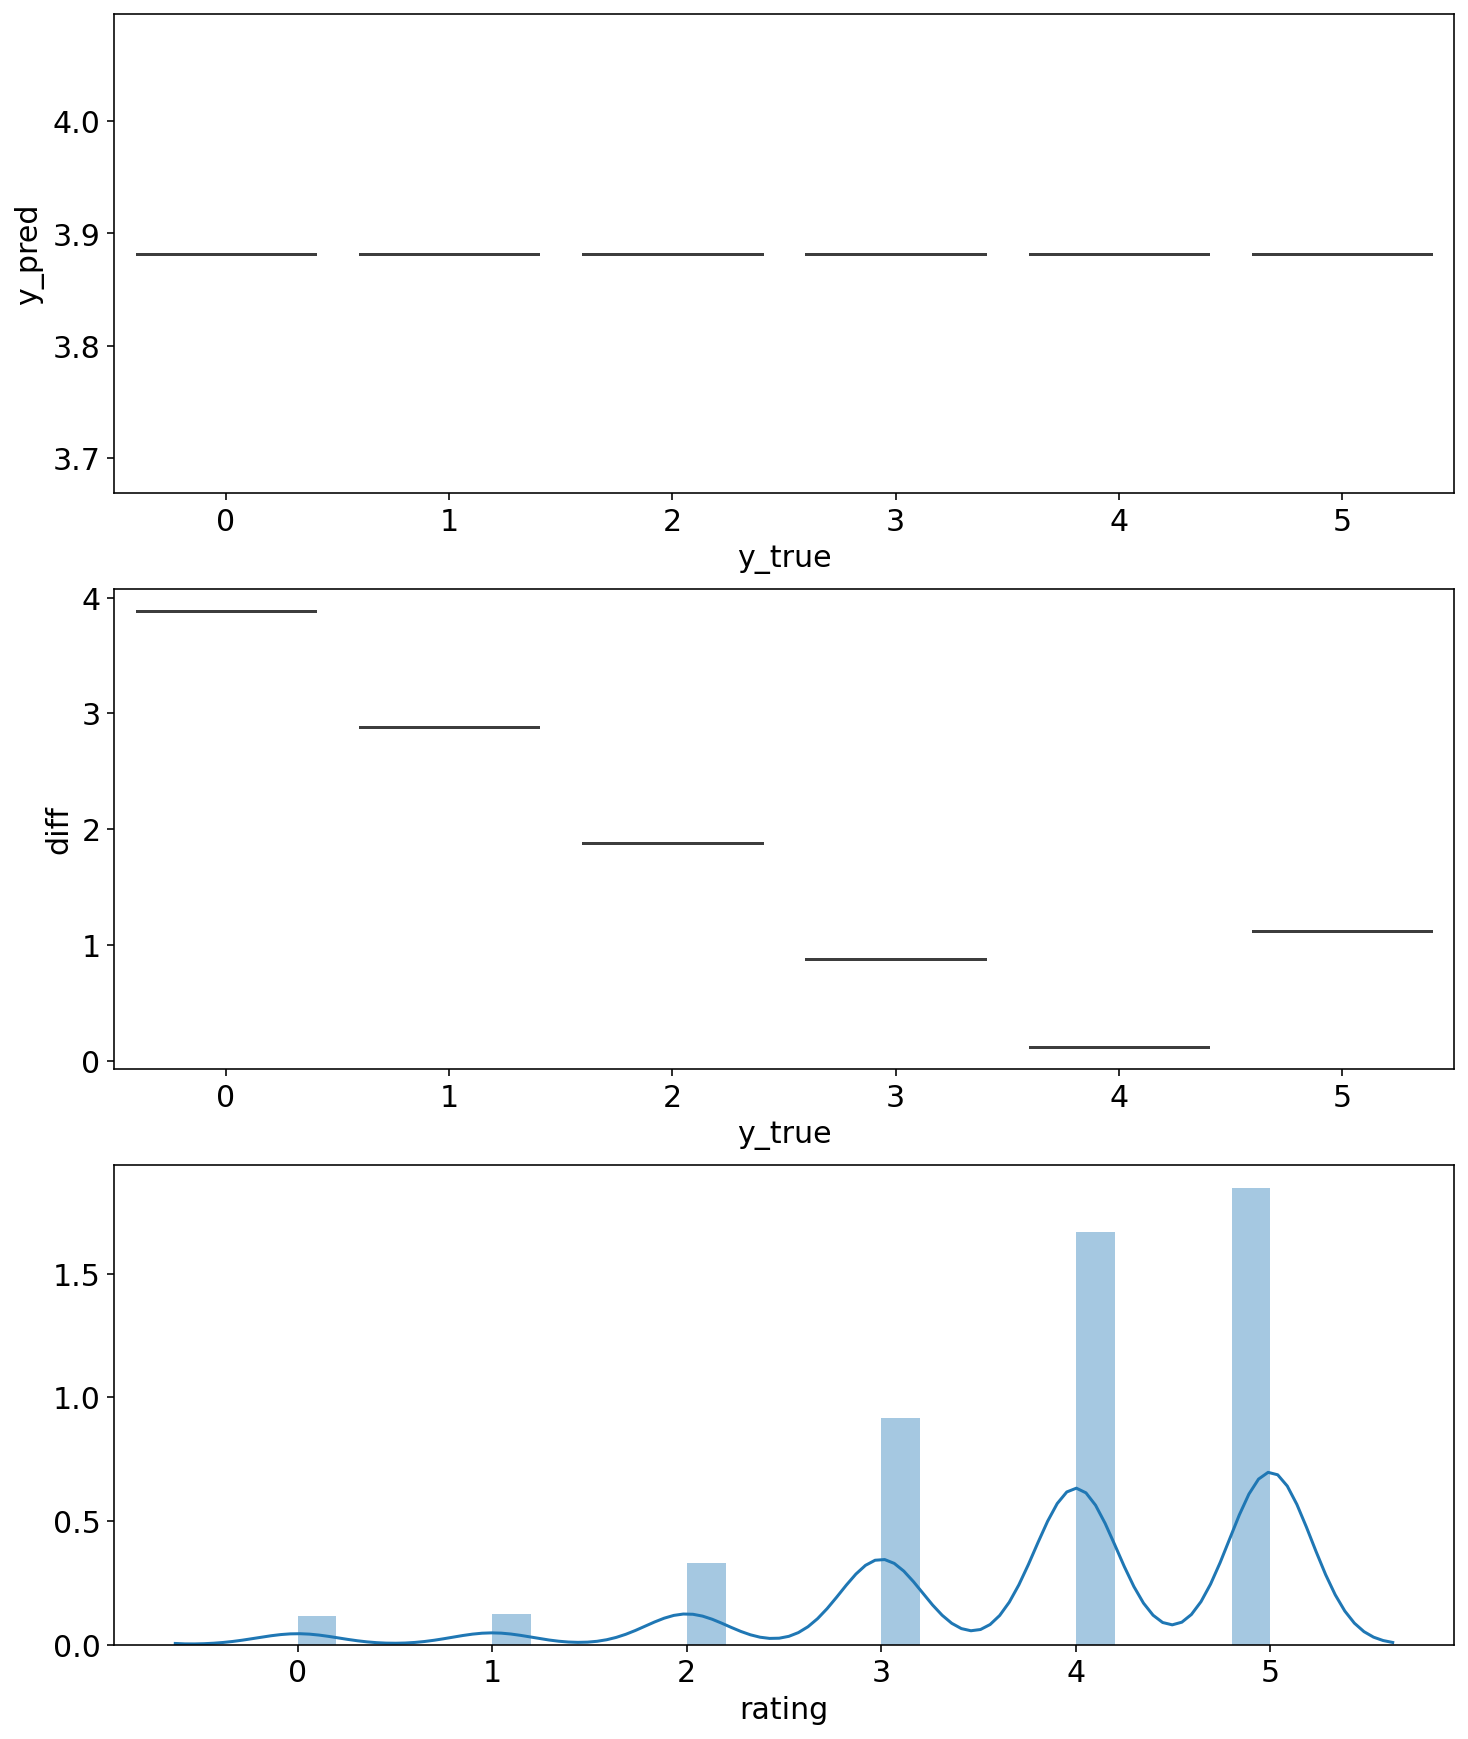

In [48]:
print_metrics(y_val, [y_train.mean()] * y_val.shape[0])

# Linear regression

In [49]:
reg = LinearRegression()
reg.fit(X_train, y_train.loc[X_train.index])

y_pred = reg.predict(X_val)

MSE: 1.4079887450677528
RMSE: 1.1865870153797204
MAE: 0.9017460771994903


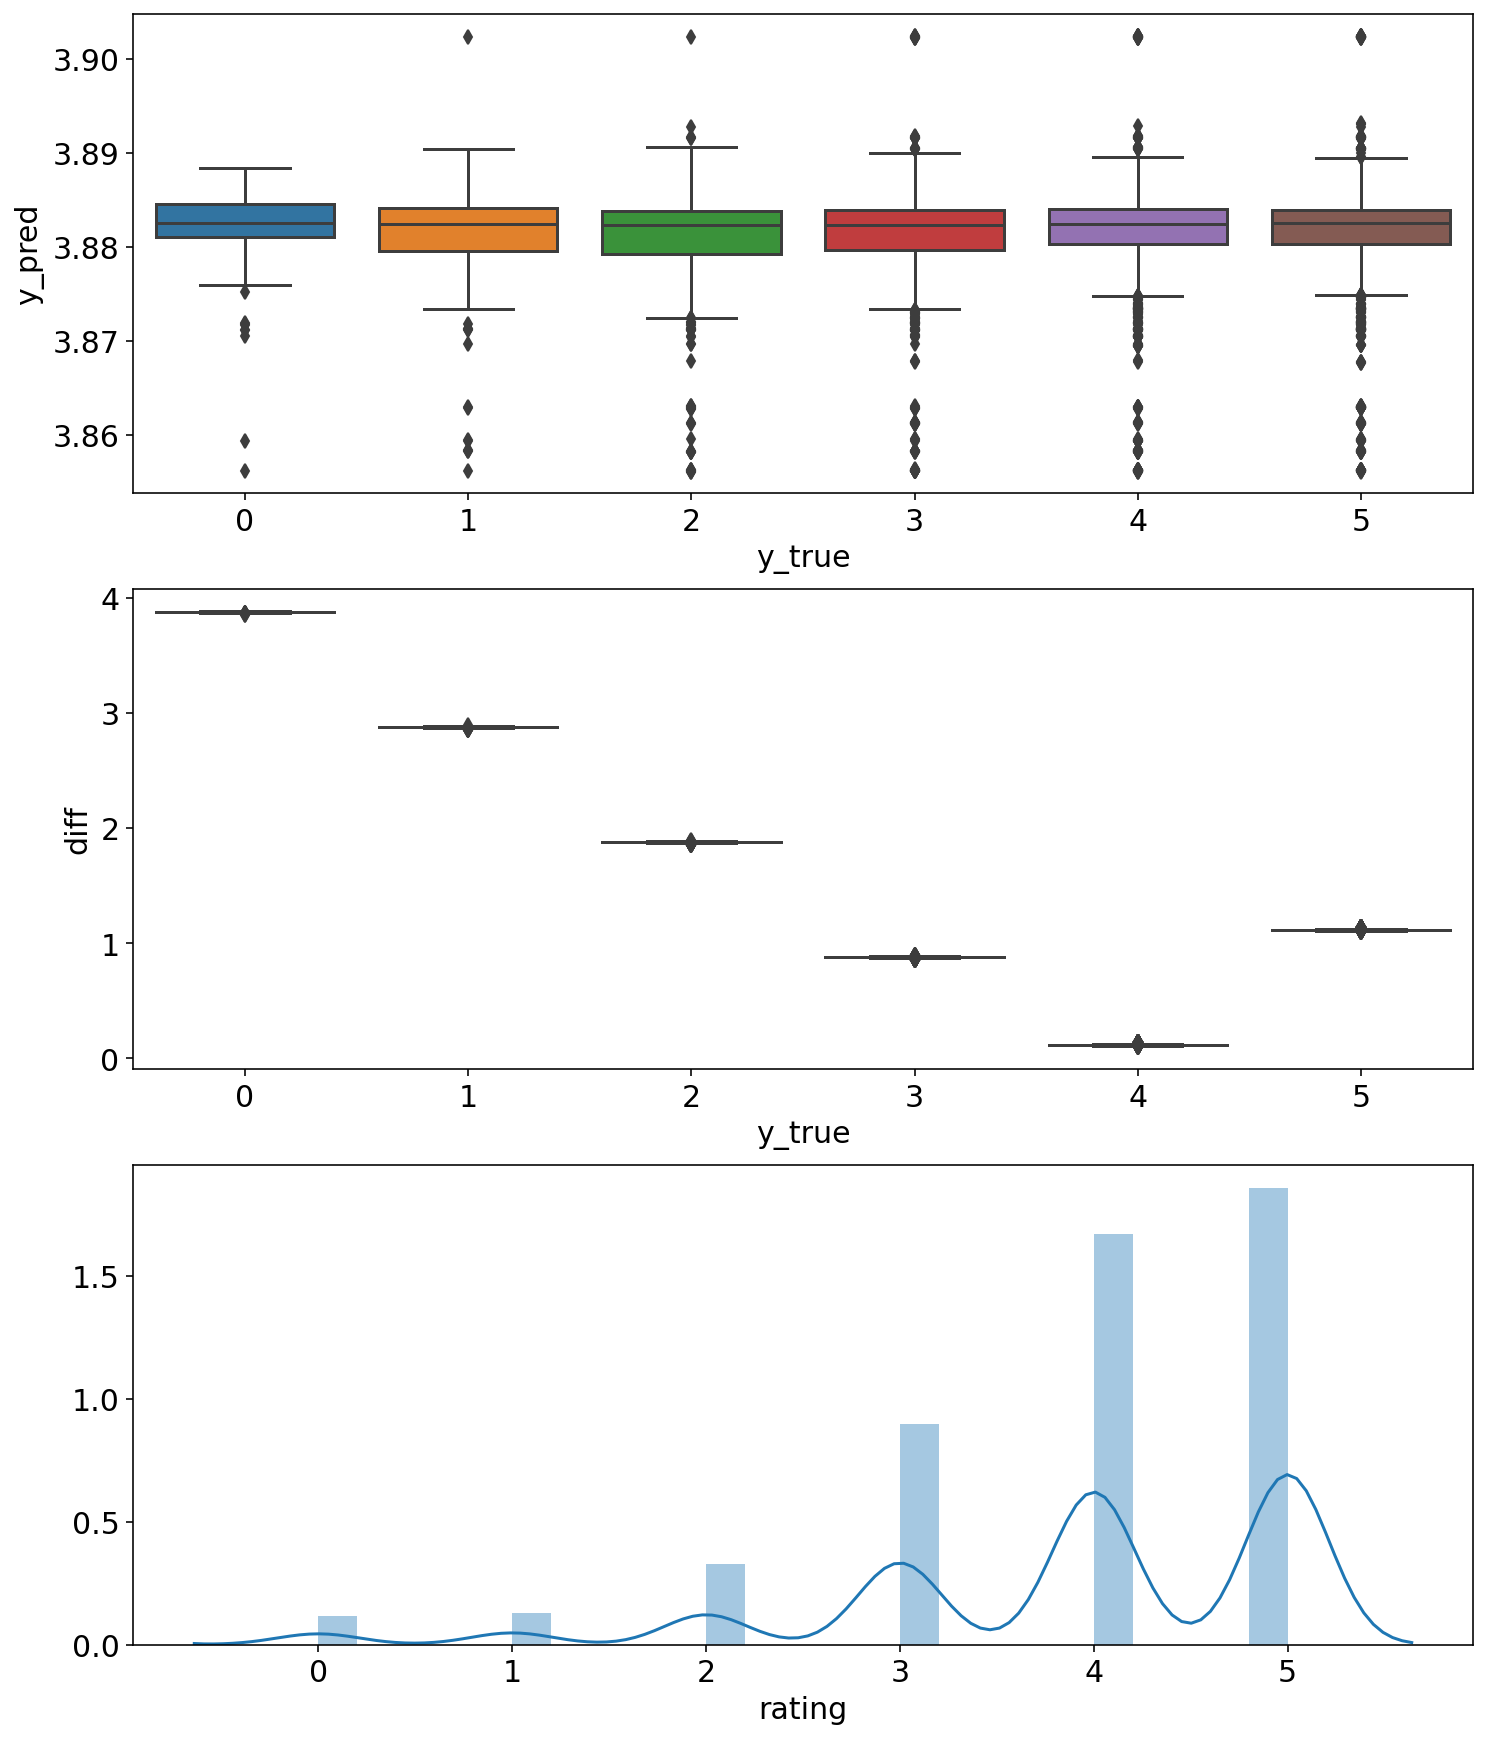

In [50]:
print_metrics(y_val[X_val.index], y_pred)

# Polynomial regression

In [12]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X_train)

model = LinearRegression()
model.fit(x_poly, y_train[X_train.index])

x_poly = polynomial_features.fit_transform(X_val)
y_pred = model.predict(x_poly)

MSE: 1.4086036239777457
RMSE: 1.1868460826820577
MAE: 0.9017704490204496


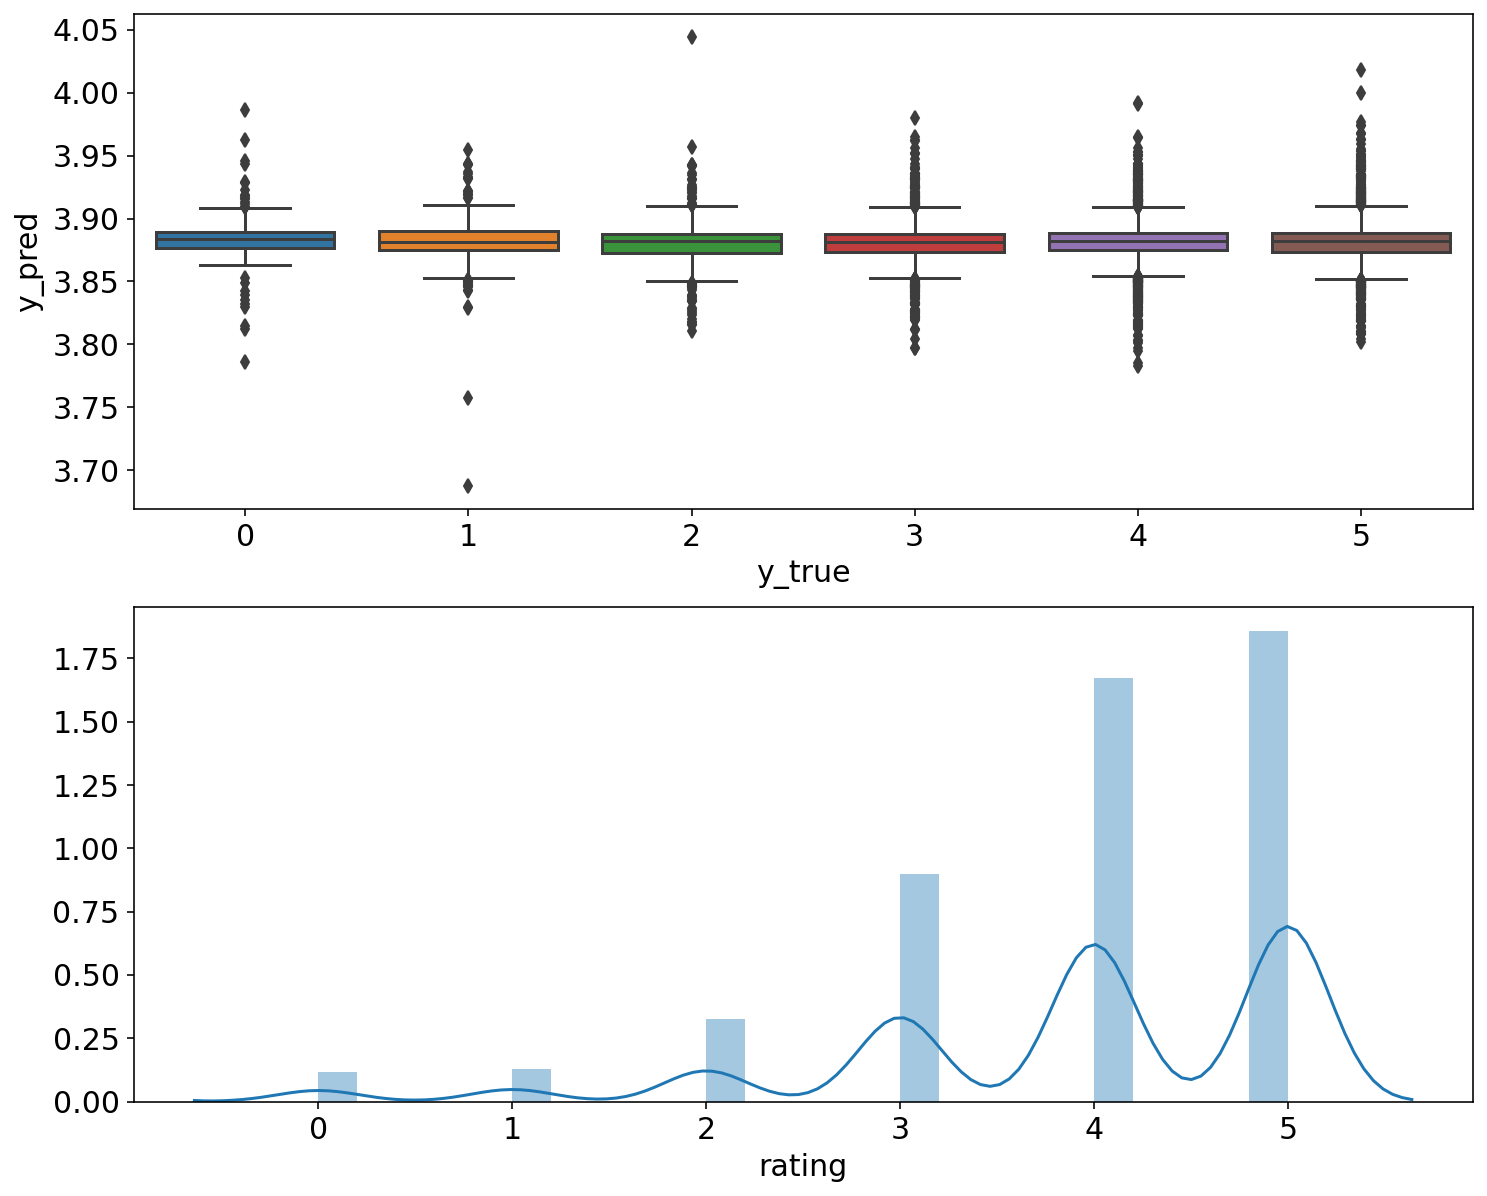

In [13]:
print_metrics(y_val[X_val.index], y_pred)

# Random forest regression

In [15]:
regr = RandomForestRegressor(max_depth=10, random_state=0)

regr.fit(X_train, y_train[X_train.index])

y_pred = regr.predict(X_val)

MSE: 1.4086003081436909
RMSE: 1.1868446857713484
MAE: 0.9018258099397993


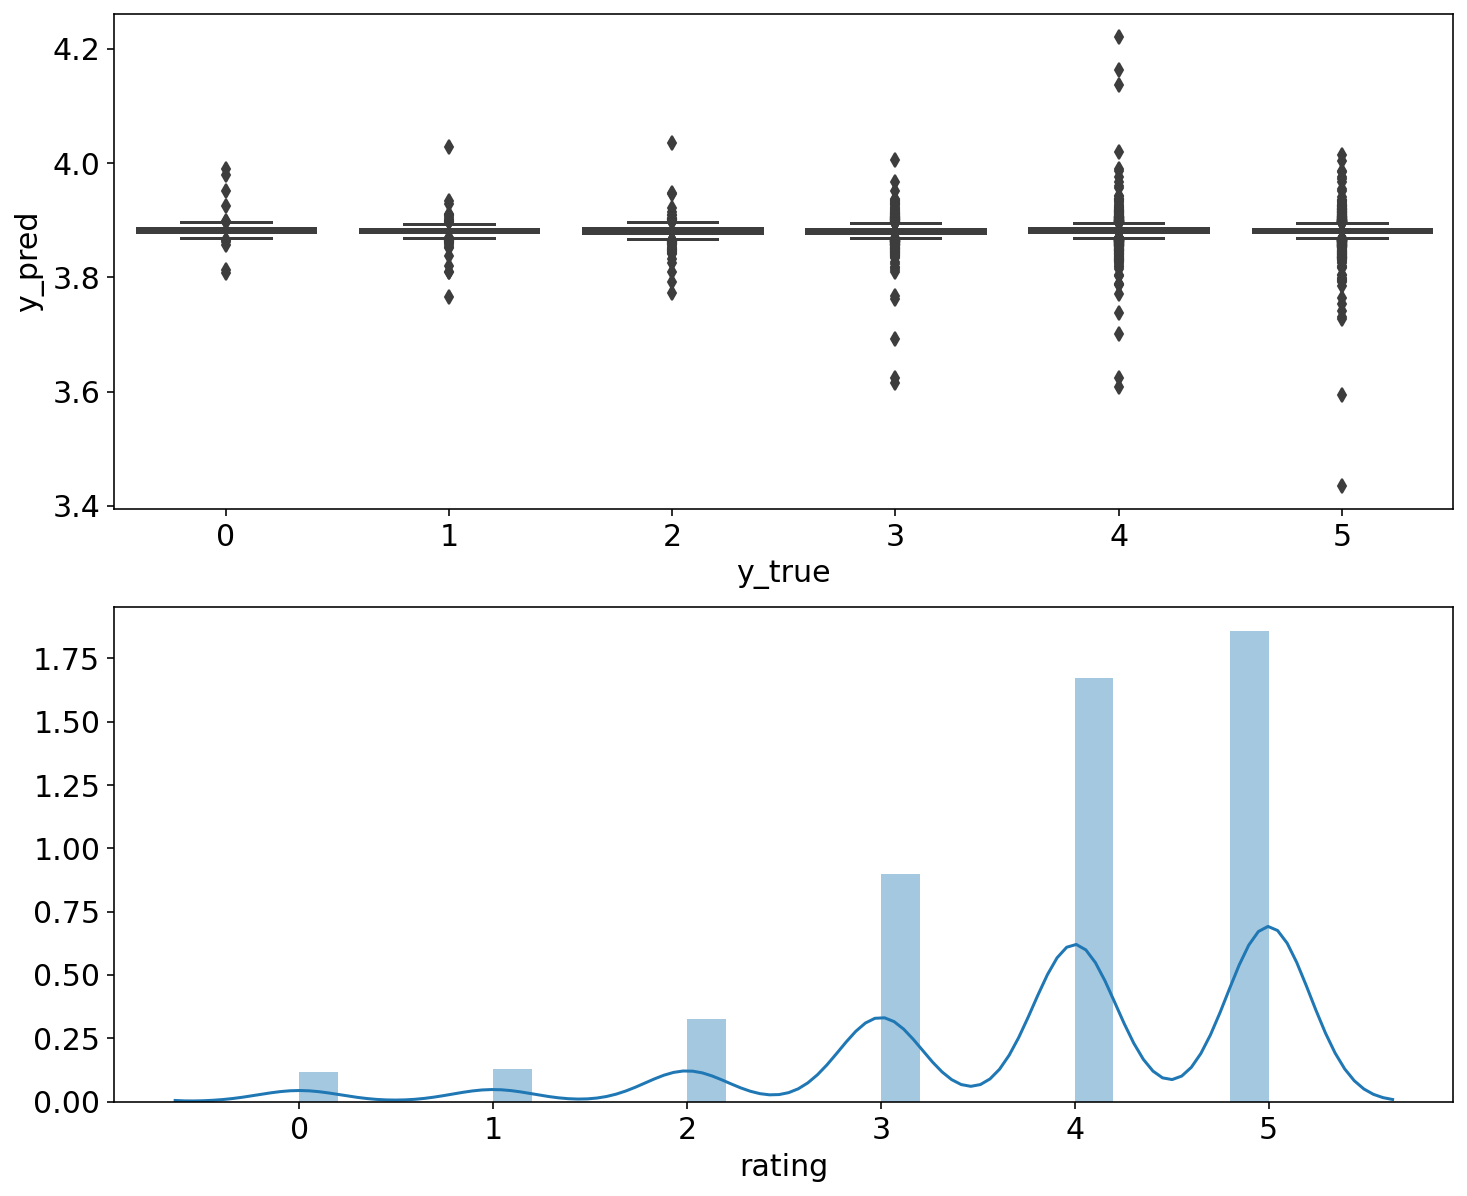

In [16]:
print_metrics(y_val[X_val.index], y_pred)

# Feature selection

## Feature importances

In [17]:
regr.feature_importances_

array([0.65735515, 0.03204051, 0.02614551, 0.02982603, 0.02235519,
       0.02980751, 0.02481772, 0.02976417, 0.02483174, 0.03137364,
       0.0307332 , 0.0319013 , 0.02904834])

# Sequential feature selection

In [ ]:
regr = RandomForestRegressor(max_depth=5, random_state=0)

sfs1 = SFS(regr,
           k_features="best",
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=5,
           n_jobs=-1)
sfs1 = sfs1.fit(X_train, y_train[X_train.index])

In [ ]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
sfs1.subsets_

# Hyperparameter tuning

In [ ]:
ind_params = {'random_state': 0}

random_params = {
    'n_estimators': range(3,30),
    'criterion': ['mse', 'mae'],
    'max_depth': [i for i in range(1, 30)] + [None],
    'min_samples_leaf': range(1,10),
    'max_features': ['auto', 'sqrt', 'log2']
}

clf = RandomForestRegressor

In [ ]:
random_optimization = RandomizedSearchCV(clf(**ind_params), param_distributions = random_params, 
                               n_iter = 1000, scoring = 'neg_mean_squared_error', cv = 10, verbose=True,
                                         random_state=42, n_jobs = -1)

In [ ]:
random_optimization.fit(X_train, y_train[X_train.index])

In [ ]:
random_optimization.best_estimator_

In [ ]:
np.sort(random_optimization.cv_results_['mean_test_score'])[-10:]

In [ ]:
indexes = np.argsort(random_optimization.cv_results_['mean_test_score'])[-10:]

for x in indexes:
    print(random_optimization.cv_results_['params'][x])